# (2022,arXiv)How Bad Are Artifacts?: Analyzing the Impact of Speech Enhancement Errors on ASR
https://arxiv.org/abs/2201.06685

In [37]:
from scipy.io import wavfile
import librosa

import numpy as np
from numpy.linalg import inv
from numpy.linalg import norm

import matplotlib.pyplot as plt   
import IPython.display as ipd

In [38]:
range(2,10)

range(2, 10)

In [39]:
path_noise = "data/wav/noise_1ch.wav"
path_noisy = "data/wav/noisy_1ch.wav"
path_speech = "data/wav/clean_1ch.wav"
path_enhan = "data/wav/t51.wav"
path_estim = "data/wav/estim.wav"

In [40]:
sr,n = wavfile.read(path_noise)
sr,s = wavfile.read(path_speech)
sr,s_hathat = wavfile.read(path_enhan)
sr,s_hat  = wavfile.read(path_estim)
sr,x = wavfile.read(path_noisy)

s_hathat = np.pad(s_hathat,(512,0))
s_hathat = s_hathat[:len(s)]

#x = s + n

n = n/32768
s = s/32768
s_hat = s_hat/32768
s_hathat = s_hathat/32768
x = x/32768

# Normalization
#n = n/np.max(np.abs(n))
#s = s/np.max(np.abs(s))
#s_hathat = s_hathat/np.max(np.abs(s_hathat))
#s_hat = s_hat/np.max(np.abs(s_hat))
#x = x/np.max(np.abs(x))


print(s.shape)
print(s_hat.shape)
print(s_hathat.shape)
print(n.shape)
print(x.shape)

(104711,)
(104711,)
(104711,)
(104711,)
(104711,)


# Test

# Functions

In [6]:
def get(s,s_hat,n,T=1024,L=1,shift=1024,n_frame = 0):
    
    length = int(len(s)/shift)

    A_s = np.zeros((T,L))
    A_sn = np.zeros((T,2*L))
    eps_s = np.eye(L,L) * 1e-14
    eps_sn = np.eye(2*L,2*L) * 1e-14
    
    if n_frame == 0 :
        n_frame = length

    list_SDR = np.zeros(n_frame)
    list_SNR = np.zeros(n_frame)
    list_SAR = np.zeros(n_frame)

    for i in range(n_frame) :
        ## per frame
        idx = (i+50)*shift
        tmp_s = s[idx:idx+T]
        tmp_s_hat = s_hat[idx:idx+T]
        tmp_n = n[idx:idx+T]

        for j in range(L):
            A_s[j:,j] = s[:T-j]
            A_sn[j:,j] = s[:T-j]
            A_sn[j:,L+j] = n[:T-j]

        ## projection matrix
        # (2)
        P_s = A_s@inv(A_s.T@A_s + eps_s )@A_s.T
        # (3)
        P_sn = A_sn@inv(A_sn.T@A_sn + eps_sn)@A_sn.T

        # (4)
        s_target = P_s@tmp_s_hat
        # (5)
        e_noise  = P_sn@tmp_s_hat - P_s@tmp_s_hat
        # (6)
        e_artif = tmp_s_hat - P_sn@tmp_s_hat

        abs_target = np.sum(np.power(s_target,2))
        # 7
        SDR = 10*np.log10(abs_target/np.sum(np.power(e_noise + e_artif,2)))
        # 8
        SNR = 10*np.log10(abs_target/np.sum(np.power(e_noise,2)))
        # 9
        SAR = 10*np.log10(np.sum(np.power(s_target+e_noise,2))/np.sum(np.power(e_artif,2)))

        list_SDR[i] = SDR
        list_SNR[i] = SNR
        list_SAR[i] = SAR
    return list_SDR,list_SNR,list_SAR

In [47]:
def GET(s,s_hat,n,T=128,L=1,shift=128,n_frame = 0):
    
    length = s.shape[1]

    A_s = np.zeros((T,L))
    A_sn = np.zeros((T,2*L))
    eps_s = np.eye(L,L) * 1e-14
    eps_sn = np.eye(2*L,2*L) * 1e-14
    
    if n_frame == 0 :
        n_frame = length

    list_SDR = np.zeros(n_frame)
    list_SNR = np.zeros(n_frame)
    list_SAR = np.zeros(n_frame)

    for i in range(n_frame) :
        ## per frame
        idx = (i+100)
        tmp_s = s[:,idx]
        tmp_s_hat = s_hat[:,idx]
        tmp_n = n[:,idx]
        

        for j in range(L):
            A_s[:,j] = s[:,idx+j]
            A_sn[:,j] = s[:,idx+j]
            A_sn[:,L+j] = n[:,idx+j]

        ## projection matrix
        # (2)
        P_s = A_s@inv(A_s.T@A_s + eps_s )@A_s.T
        # (3)
        #P_sn = A_sn@inv(A_sn.T@A_sn + eps_sn)@A_sn.T
        P_sn = A_sn@inv(A_sn.T@A_sn)@A_sn.T

        # (4)
        s_target = P_s@tmp_s_hat
        # (5)
        e_noise  = P_sn@tmp_s_hat - P_s@tmp_s_hat
        # (6)
        #e_artif = tmp_s_hat - P_sn@tmp_s_hat
        
        e_artif = tmp_s_hat - P_s@tmp_s_hat
        # => equal to e_artif = tmp_s_hat -s_target -e_noise

        abs_target = np.sum(np.power(s_target,2))
        # 7
        SDR = 10*np.log10(abs_target/np.sum(np.power(e_noise + e_artif,2)))
        # 8
        SNR = 10*np.log10(abs_target/np.sum(np.power(e_noise,2)))
        # 9
        SAR = 10*np.log10(np.sum(np.power(s_target+e_noise,2))/np.sum(np.power(e_artif,2)))
        #SAR = 10*np.log10(np.sum(np.power(s_target,2))/np.sum(np.power(e_artif,2)))
        
        print('noise : ' + str(np.sum(np.power(e_noise,2))) + " | artif : "+ str(np.sum(np.power(e_artif,2))) )
        
        #print(np.sum(np.power(e_artif,2)))
        list_SDR[i] = SDR
        list_SNR[i] = SNR
        list_SAR[i] = SAR
    return list_SDR,list_SNR,list_SAR

# Display

## s

## n

## s hat

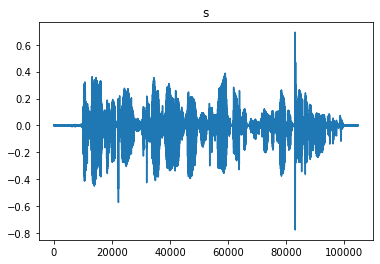

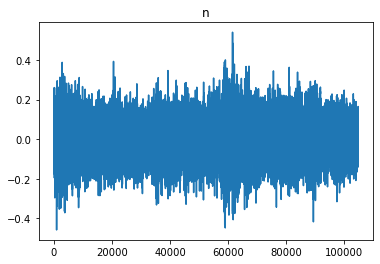

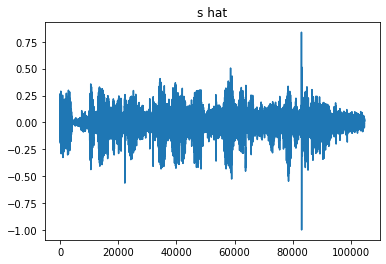

In [139]:
plt.figure()
plt.plot(s)
plt.title("s")
plt.figure()
plt.plot(n)
plt.title("n")
plt.figure()
plt.plot(s_hat)
plt.title("s hat")


ipd.display(ipd.Markdown('## s'))
ipd.display(ipd.Audio(s, rate=sr))
ipd.display(ipd.Markdown('## n'))
ipd.display(ipd.Audio(n, rate=sr))
ipd.display(ipd.Markdown('## s hat'))
ipd.display(ipd.Audio(s_hat, rate=sr))

In [141]:
print(np.max(np.abs(x)))
print(np.max(np.abs(n)))
print(np.max(np.abs(s)))
print(np.max(np.abs(s+n)))

1.0
0.54058837890625
0.7772216796875
1.000030517578125


# Orthogonal projection based decomposition

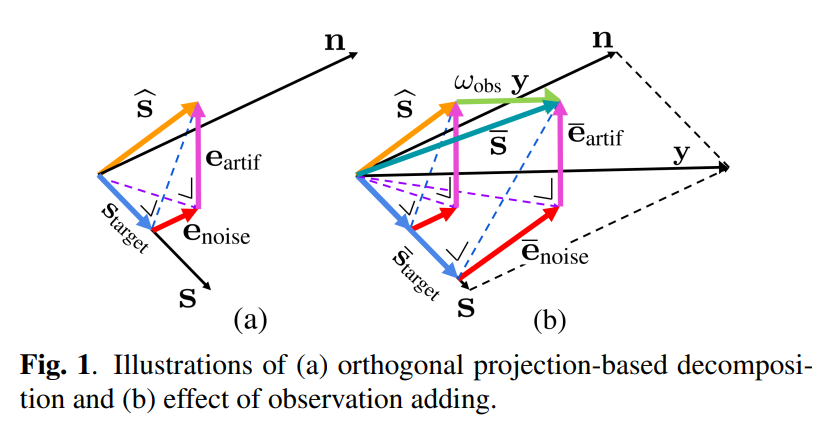

$$  \mathbf{P_s} = \mathbf{A_s}(\mathbf{A_s}^T\mathbf{A_s})^{-1}\mathbf{A_s}^T $$
$$  \mathbf{P_{s,n}} = \mathbf{A_{s,n}}(\mathbf{A_{s,n}}^T\mathbf{A_{s,n}})^{-1}\mathbf{A_{s,n}}^T $$

$$ \mathbf{A_s} = [\mathbf{s}^{\tau = 0}, . . . , \mathbf{s}^{\tau = L-1}] \in \mathbb{R} ^{T \times L} $$ 
$$ \mathbf{A_{s,n}} =  [\mathbf{s}^{\tau = 0}, . . . , \mathbf{s}^{\tau = L-1} , \mathbf{n}^{\tau = 0}, . . . , \mathbf{n}^{\tau = L-1}]  \in \mathbb{R} ^{T \times 2L} $$ 

$$ \mathbf{s}_\text{target} = \mathbf{P_s}\widehat{\mathbf{s}} $$
$$ \mathbf{e}_\text{noise} = \mathbf{P_{s,n}}\widehat{\mathbf{s}} -  \mathbf{P_s}\widehat{\mathbf{s}} $$
$$ \mathbf{e}_\text{artif} = \widehat{\mathbf{s}} -  \mathbf{P_{s,n}}\widehat{\mathbf{s}} $$

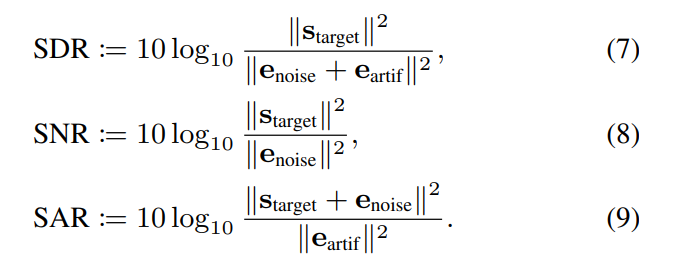

SAR 이 Signal-to-Artifact 인데 왜 noise 항을 넣어 두는가? 

# artifacts on Time Domain

In [ ]:
list_SDR,list_SNR,list_SAR = get(s,x,n,T=104711,n_frame=1)

ipd.display(ipd.Markdown('# s, x, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s_hat, n

Text(0.5, 1.0, 'SAR')

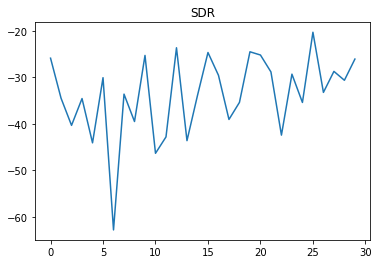

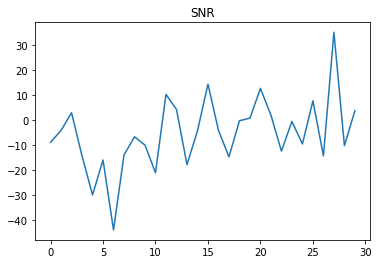

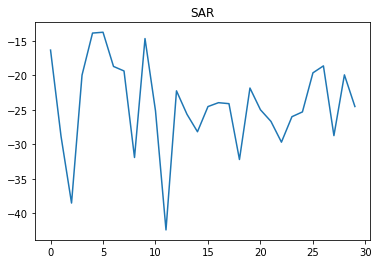

In [123]:
list_SDR,list_SNR,list_SAR = get(s,s_hat,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s_hat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s, n

Text(0.5, 1.0, 'SAR')

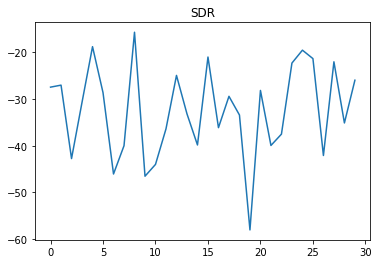

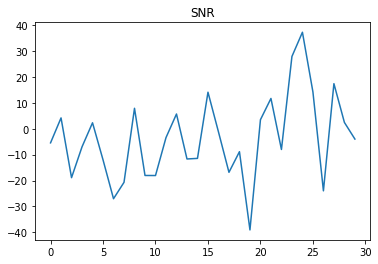

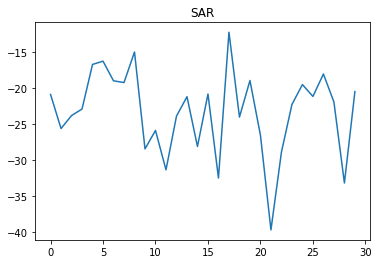

In [124]:
list_SDR,list_SNR,list_SAR = get(s,s,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s_hathat, n

Text(0.5, 1.0, 'SAR')

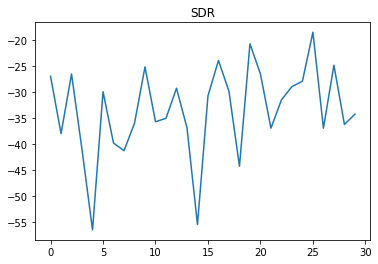

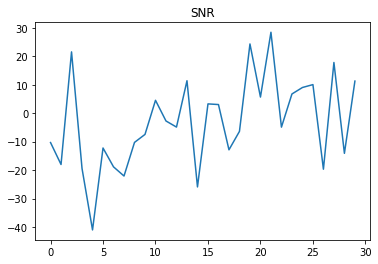

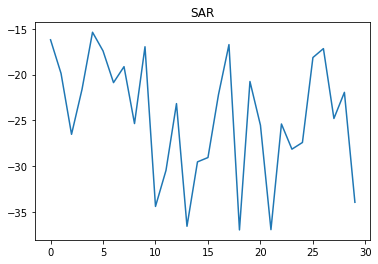

In [125]:
list_SDR,list_SNR,list_SAR = get(s,s_hathat,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s_hathat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s_hathat, n, OA 0.3

Text(0.5, 1.0, 'SAR')

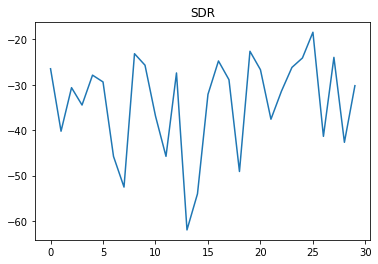

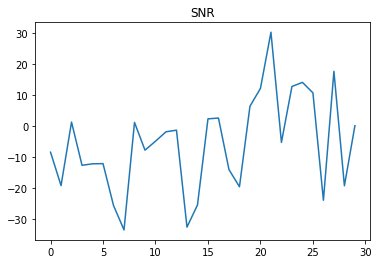

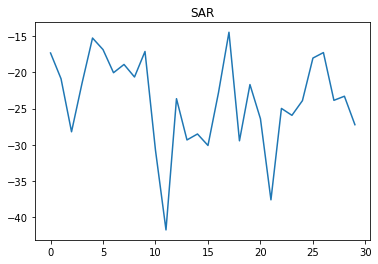

In [126]:
list_SDR,list_SNR,list_SAR = get(s,s_hathat+0.5*s,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s_hathat, n, OA 0.3'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, n, n

Text(0.5, 1.0, 'SAR')

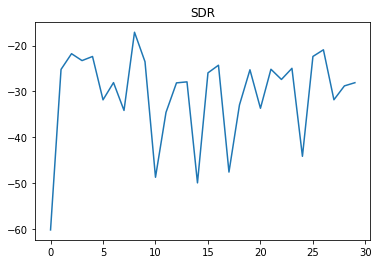

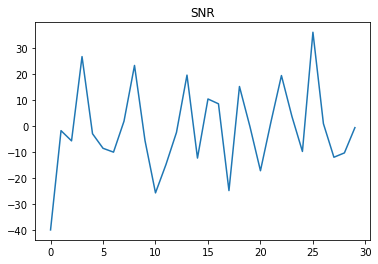

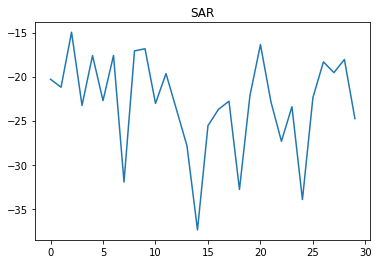

In [127]:
list_SDR,list_SNR,list_SAR = get(s,n,n,n_frame=30)

ipd.display(ipd.Markdown('# s, n, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# mag domain

In [42]:
N = np.abs(librosa.stft(n))
S = np.abs(librosa.stft(s))
X = np.abs(librosa.stft(x))
S_hat = np.abs(librosa.stft(s_hat))
S_hathat = np.abs(librosa.stft(s_hathat))

print(N.shape)
print(S.shape)
print(X.shape)
print(S_hat.shape)
print(S_hathat.shape)

(1025, 205)
(1025, 205)
(1025, 205)
(1025, 205)
(1025, 205)


noise : 1834.4618943530159 | artif : 2572.814992334401
noise : 2239.295605098611 | artif : 3382.4093519628714
noise : 2102.13716178846 | artif : 2447.547246210543
noise : 2617.892011571671 | artif : 2756.3093272780343
noise : 3353.108632033347 | artif : 3682.9980548590397
noise : 2315.9505314974986 | artif : 2619.778054856706
noise : 2208.752088205846 | artif : 2630.590537216399
noise : 2484.9446718304152 | artif : 2756.321338615258
noise : 2258.526809914865 | artif : 2368.7172695621007
noise : 2130.8438195054227 | artif : 2472.1522073258375
noise : 1949.5340085724351 | artif : 2791.7001673254713
noise : 2944.8183143102833 | artif : 3857.760817490746
noise : 3789.0765928285196 | artif : 4782.878360578302
noise : 3666.9471054702076 | artif : 4656.406222408908
noise : 5709.882926631593 | artif : 7099.589737424768
noise : 6543.179303107643 | artif : 7586.720693928413
noise : 4083.9470327506424 | artif : 5528.704743848663
noise : 3719.6665900166126 | artif : 4438.01455658769
noise : 3250.8

# s, X, n

-2.515535441292385
3.7034291511867656
4.662977957158171


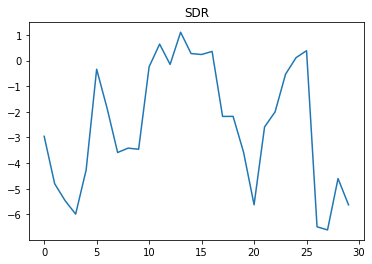

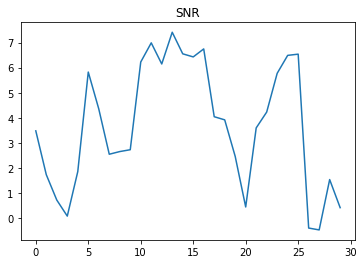

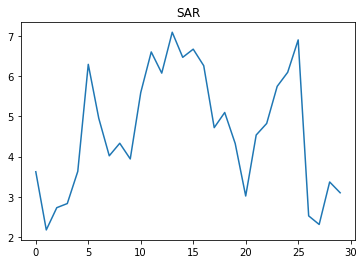

In [48]:
list_SDR,list_SNR,list_SAR = GET(S,X,N,L=5,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, X, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

print(np.mean(list_SDR))
print(np.mean(list_SNR))
print(np.mean(list_SAR))

noise : 140.1497555328345 | artif : 711.9027034607989
noise : 127.90489417082993 | artif : 750.6068056698834
noise : 209.20946913487725 | artif : 613.0710125210418
noise : 359.893217587154 | artif : 772.8298225211722
noise : 385.6308731944167 | artif : 878.0193348886236
noise : 207.07016871111523 | artif : 573.3806586545315
noise : 150.01057884736997 | artif : 626.7879577722988
noise : 147.66555809481076 | artif : 577.1663908343627
noise : 212.84131626037313 | artif : 476.44597984910064
noise : 346.465419601818 | artif : 1007.970335717096
noise : 395.95240466650193 | artif : 1370.6995551424677
noise : 719.979343913848 | artif : 1892.850243528556
noise : 818.4299417935603 | artif : 1777.4644392921577
noise : 929.0551590696647 | artif : 1814.7596730848927
noise : 1295.4101359378278 | artif : 2740.4723120139433
noise : 1372.947197476237 | artif : 2947.314795986733
noise : 387.31656835242904 | artif : 1651.6803212105237
noise : 450.4014458117945 | artif : 1275.021084371338
noise : 220.3160

# s, S_hat, n

2.830093562735581
10.626646479434624
6.440882884486909


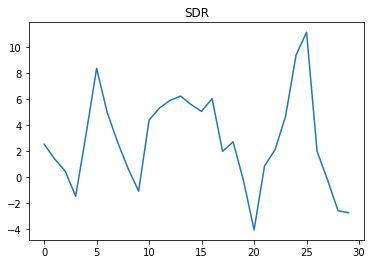

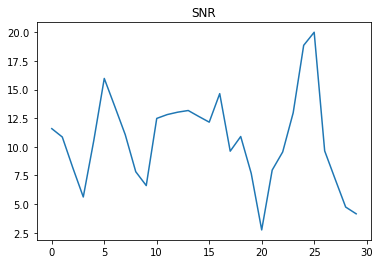

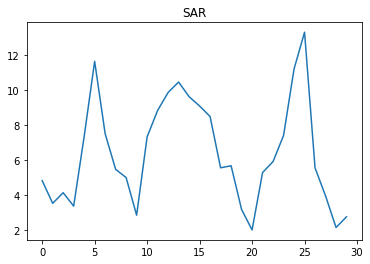

In [49]:
list_SDR,list_SNR,list_SAR = GET(S,S_hat,N,L=5,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, S_hat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

print(np.mean(list_SDR))
print(np.mean(list_SNR))
print(np.mean(list_SAR))

# s, S_hathat, n

4.000669983895665
11.67832818000349
7.7264054613526785


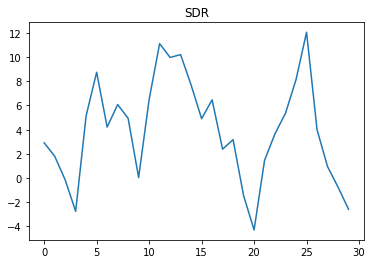

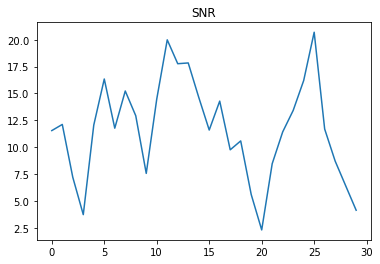

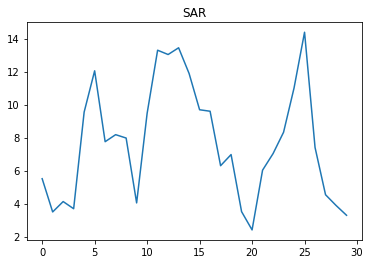

In [45]:
list_SDR,list_SNR,list_SAR = GET(S,S_hathat,N,L=5,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, S_hathat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

print(np.mean(list_SDR))
print(np.mean(list_SNR))
print(np.mean(list_SAR))

noise : 8.323662816813783e-26 | artif : 5.710141737299754e-26
noise : 3.3275252053515287e-26 | artif : 9.202089548308953e-27
noise : 2.5898605103953516e-26 | artif : 2.2121163289618628e-26
noise : 3.1352771192281022e-27 | artif : 1.384040167299719e-26
noise : 1.0156792185157839e-25 | artif : 6.786793579018963e-26
noise : 1.9457654369790933e-25 | artif : 1.6803418540284528e-25
noise : 2.2616557970610625e-26 | artif : 8.526090712534881e-27
noise : 1.7752856417845383e-26 | artif : 1.1134510857567626e-26
noise : 1.0438788134165373e-27 | artif : 3.5833777539325373e-28
noise : 5.385124557468934e-26 | artif : 9.745330851182426e-27
noise : 2.188693565720499e-25 | artif : 4.0284371572720794e-26
noise : 1.0898082716542345e-25 | artif : 7.471316295525515e-26
noise : 6.182835954469614e-26 | artif : 3.5032143386700067e-26
noise : 2.4698958387914463e-25 | artif : 2.1070881328361914e-25
noise : 4.926360261710668e-25 | artif : 2.517670630125395e-25
noise : 5.177062707754782e-25 | artif : 1.37047427785

# s, S, n

284.75328344585165
287.4668781533189
290.98920576524546


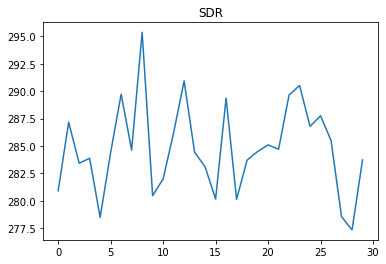

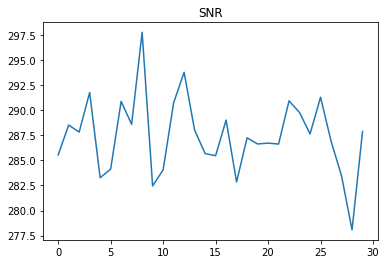

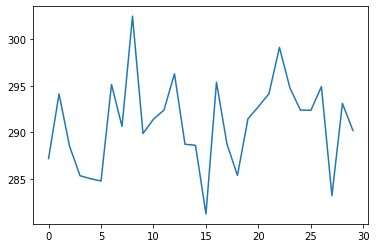

In [50]:
list_SDR,list_SNR,list_SAR = GET(S,S,N,L=5,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, S, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)

print(np.mean(list_SDR))
print(np.mean(list_SNR))
print(np.mean(list_SAR))

noise : 2605.430906497635 | artif : 2605.4309064976287
noise : 3045.8568651697574 | artif : 3045.856865169752
noise : 2302.006256084443 | artif : 2302.0062560844412
noise : 2749.505553412529 | artif : 2749.505553412514
noise : 3966.0186150694685 | artif : 3966.0186150694612
noise : 3093.708664806999 | artif : 3093.7086648069935
noise : 2810.0658120004537 | artif : 2810.0658120004446
noise : 3252.548821160909 | artif : 3252.54882116092
noise : 2698.653686377909 | artif : 2698.653686377908
noise : 2620.056734265458 | artif : 2620.0567342654376
noise : 2830.118908582106 | artif : 2830.1189085820774
noise : 4397.0373813317365 | artif : 4397.037381331754
noise : 4749.876421445193 | artif : 4749.876421445214
noise : 5285.047171219994 | artif : 5285.047171219976
noise : 7984.054394152074 | artif : 7984.054394152075
noise : 7995.051616382282 | artif : 7995.051616382235
noise : 5248.3049215889405 | artif : 5248.304921588933
noise : 4292.160474714198 | artif : 4292.160474714206
noise : 3710.7257

# s, N, n

-6.680736569302218
-0.6601366560225986
2.7804779541516367


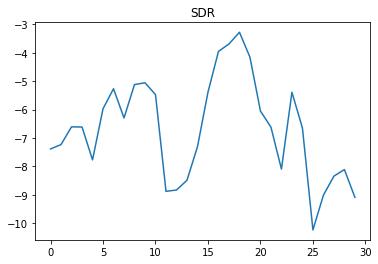

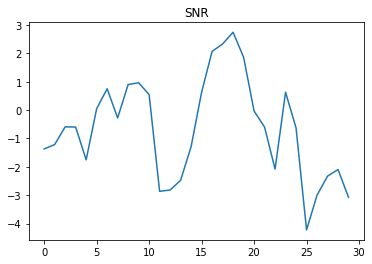

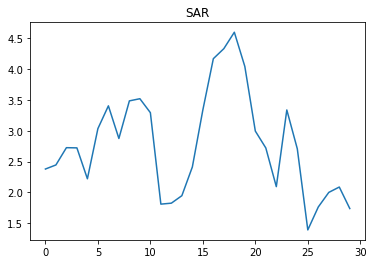

In [51]:
list_SDR,list_SNR,list_SAR = GET(S,N,N,L=5,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, N, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

print(np.mean(list_SDR))
print(np.mean(list_SNR))
print(np.mean(list_SAR))